In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDistDDE_with_adjoint_accel as nddde
import src.bio_eqn_case.bio_eqn_modcall as bio
from src.bio_eqn_case.Bio_Eqn_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle
import scipy as sc
from scipy import signal

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

## Load data

In [4]:
os.chdir(basedir)
    
with open(os.path.join('neuralClosureModels/final_paper_scripts', 'nODE_C2i_Exp3_predictions.pkl'), 'rb') as output:
    nODE_dict = pickle.load(output)
    
with open(os.path.join('neuralClosureModels/final_paper_scripts', 'nDDE_C2_Exp3_predictions.pkl'), 'rb') as output:
    nDDE_dict = pickle.load(output)
    
with open(os.path.join('neuralClosureModels/final_paper_scripts', 'nDistDDE_C13g_Exp3_predictions.pkl'), 'rb') as output:
    nDistDDE_dict = pickle.load(output)

In [5]:
t = tf.concat([nODE_dict['t'], nODE_dict['val_t']], axis=0)

nnpzd = tf.concat([nODE_dict['true_x_low_complex'], nODE_dict['val_true_x_low_complex']], axis=0)

npz = tf.concat([nODE_dict['x_low_complex'], nODE_dict['val_x_low_complex']], axis=0)

nODE_pred = nODE_dict['pred_y']
nDDE_pred = nDDE_dict['pred_y']
nDistDDE_pred = nDistDDE_dict['pred_y']

## Plot RMSE 

In [6]:
npz_error = tf.squeeze(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(nnpzd, npz), axis=-1)), axis=-1)
nODE_error = tf.squeeze(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(nODE_pred, nnpzd), axis=-1)), axis=-1)
nDDE_error = tf.squeeze(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(nDDE_pred, nnpzd), axis=-1)), axis=-1)
nDistDDE_error = tf.squeeze(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(nDistDDE_pred, nnpzd), axis=-1)), axis=-1)

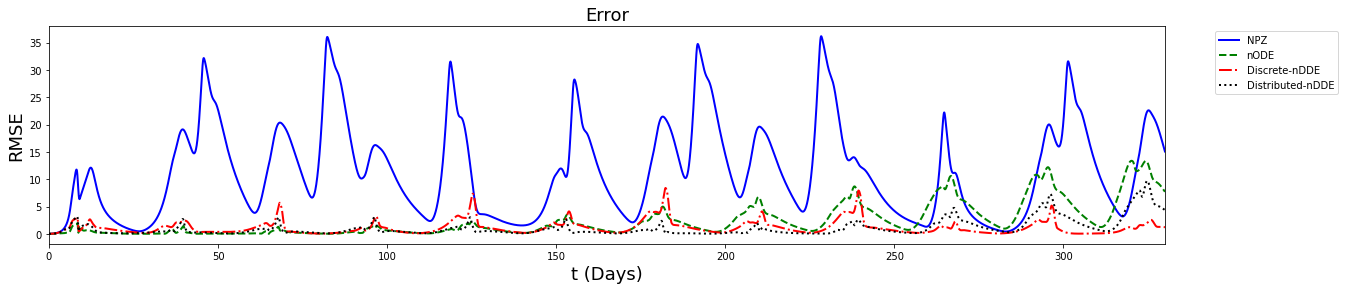

In [17]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']
rom_dims = 3

fig = plt.figure(figsize=(20, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Error', fontsize=18)
ax.set_xlabel('t (Days)', fontsize=18)
ax.set_ylabel('RMSE', fontsize=18)
ax.set_xlim(min(t.numpy()), max(t.numpy()))
# ax.set_ylim(-1, 1)

ax.plot(t.numpy(), npz_error.numpy(), 'b'+'-', label = 'NPZ ', linewidth=2)
ax.plot(t.numpy(), nODE_error.numpy(), 'g'+'--', label = 'nODE', linewidth=2)
ax.plot(t.numpy(), nDDE_error.numpy(), 'r'+'-.', label = 'Discrete-nDDE', linewidth=2)
ax.plot(t.numpy(), nDistDDE_error.numpy(), 'k'+':', label = 'Distributed-nDDE', linewidth=2)

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

In [8]:
def compute_xcorr(sig1, sig2):
    corr_list = []
    for i in range(3): 
        corr = signal.correlate(sig1[:, i], sig2[:, i]) 
        corr /= np.max(corr)
        corr_list.append(np.expand_dims(corr, axis=-1))
        
    corr_list = np.concatenate(corr_list, axis=-1)
    corr = np.mean(corr_list, axis=-1)
    lags = signal.correlation_lags(len(sig1[:, 0]), len(sig2[:, 0]))
    return corr, lags

In [9]:
npz.numpy().shape

(6590, 1, 3)

In [10]:
corr_base, lag = compute_xcorr(npz.numpy()[1200:, 0, :], nnpzd.numpy()[1200:, 0, :])
corr_nODE, lag = compute_xcorr(nODE_pred.numpy()[1200:, 0, :], nnpzd.numpy()[1200:, 0, :])
corr_nDDE, lag = compute_xcorr(nDDE_pred.numpy()[1200:, 0, :], nnpzd.numpy()[1200:, 0, :])
corr_nDistDDE, lag = compute_xcorr(nDistDDE_pred.numpy()[1200:, 0, :], nnpzd.numpy()[1200:, 0, :])

lag = lag * (30./600)

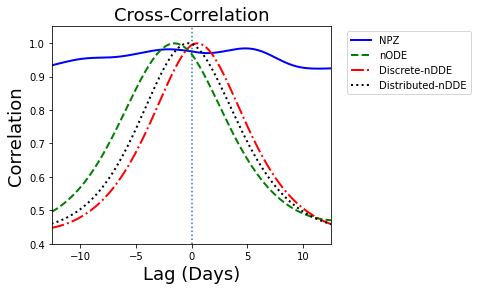

In [16]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']
rom_dims = 3

fig = plt.figure(figsize=(5, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Cross-Correlation', fontsize=18)
ax.set_xlabel('Lag (Days)', fontsize=18)
ax.set_ylabel('Correlation', fontsize=18)
ax.set_ylim(0.4, 1.05)

ax.plot(lag, corr_base, 'b'+'-', label = 'NPZ ', linewidth=2)
ax.plot(lag, corr_nODE, 'g'+'--', label = 'nODE', linewidth=2)
ax.plot(lag, corr_nDDE, 'r'+'-.', label = 'Discrete-nDDE', linewidth=2)
ax.plot(lag, corr_nDistDDE, 'k'+':', label = 'Distributed-nDDE', linewidth=2)
ax.vlines(0., 0.4, 1.05, colors=None, linestyles='dotted')

ax.set_xlim(-250 * (30./600), 250 * (30./600))

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

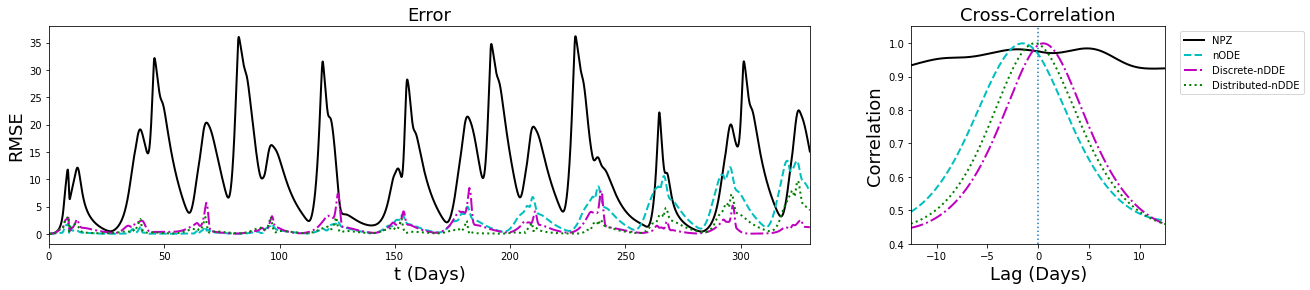

In [12]:
# fig = plt.figure(figsize=(20, 4), facecolor='white')
# ax = fig.add_subplot(121, figsize=(10, 4))

f, (ax, ax_corr) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 4), facecolor='white')

ax.cla()
ax.set_title('Error', fontsize=18)
ax.set_xlabel('t (Days)', fontsize=18)
ax.set_ylabel('RMSE', fontsize=18)
ax.set_xlim(min(t.numpy()), max(t.numpy()))
# ax.set_ylim(-1, 1)

ax.plot(t.numpy(), npz_error.numpy(), 'k'+'-', label = 'NPZ ', linewidth=2)
ax.plot(t.numpy(), nODE_error.numpy(), 'c'+'--', label = 'nODE', linewidth=2)
ax.plot(t.numpy(), nDDE_error.numpy(), 'm'+'-.', label = 'Discrete-nDDE', linewidth=2)
ax.plot(t.numpy(), nDistDDE_error.numpy(), 'g'+':', label = 'Distributed-nDDE', linewidth=2)


# ax_corr = fig.add_subplot(122)

ax_corr.cla()
ax_corr.set_title('Cross-Correlation', fontsize=18)
ax_corr.set_xlabel('Lag (Days)', fontsize=18)
ax_corr.set_ylabel('Correlation', fontsize=18)
ax_corr.set_ylim(0.4, 1.05)

ax_corr.plot(lag, corr_base, 'k'+'-', label = 'NPZ ', linewidth=2)
ax_corr.plot(lag, corr_nODE, 'c'+'--', label = 'nODE', linewidth=2)
ax_corr.plot(lag, corr_nDDE, 'm'+'-.', label = 'Discrete-nDDE', linewidth=2)
ax_corr.plot(lag, corr_nDistDDE, 'g'+':', label = 'Distributed-nDDE', linewidth=2)
ax_corr.vlines(0., 0.4, 1.05, colors=None, linestyles='dotted')

ax_corr.set_xlim(-250 * (30./600), 250 * (30./600))

ax_corr.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 